# TFG FER

Este notebook contiene el código necesario para la creación de un modelo de clasificación de imágenes de rostros humanos en función del estres emocional que presentan. Para ello, se va a utuilzar un dataset de imágenes pero de tipo .npy que contiene las imágenes de los rostros pero con un formato diferente al habitual, ya que las imágenes están en formato de matriz de píxeles. 

Los pasos a seguir para la creación del modelo son los siguientes:

1. Importar las librerías necesarias
2. Cargar el dataset
3. Preprocesamiento de los datos
4. Creación del modelo
5. Entrenamiento del modelo
6. Evaluación del modelo

In [1]:
import os
import tensorflow as tf

# Configurar TensorFlow para que use la CPU
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Ahora, al crear sesiones de TensorFlow, solo se usará la CPU
# Verificar que realmente no estamos utilizando ninguna GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2024-07-18 02:25:36.684174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-07-18 02:25:37.642502: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/fgalan/miniconda3/lib/:/home/fgalan/miniconda3/lib/:/home/fgalan/miniconda3/envs/myenv/lib/
2024-07-18 02:25:37.642613: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/fgalan/miniconda3/lib/:/home/fgalan/miniconda3/lib/:/home/fgalan/miniconda3/envs/myenv/lib/
2024-07-18 02:25:37.642619: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Num GPUs Available:  2


2024-07-18 02:25:38.760748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-18 02:25:38.761036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-18 02:25:38.779416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-18 02:25:38.779666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-18 02:25:38.779886: I tensorflow/compiler/xla/stream_executo

## 1. Importar las librerías necesarias

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Comprobar version tensorflow
print(tf.__version__)

# Comprobar que estamos usando la GPU
print(tf.config.list_physical_devices())

2.11.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## 2. Cargar el dataset

Como se ha mencionado anteriormente, el dataset que se va a utilizar es un archivo .npy que contiene las imágenes de los rostros en formato de matriz de píxeles. Para cargar el dataset, se utiliza la función `np.load()` de la librería NumPy.

Nuestro dataset esta dividido en dos partes, una con las imágenes y otra con las etiquetas. Para la recolección de imágenes se ha utilizado un dataset cuyo escenario experimental consiste en pasos que causan o no causan estrés; lectura de escritura en el idioma nativo, entrevista en el idioma nativo, lectura de escritura en idioma no nativo, entrevista en idioma no nativo.

Por lo tanto las distintas carpetas que forma el dataset son:

- **Native_Language_Script_Reading** (BAJO ESTRES-NEUTRAL)
- **Native_Language_Interview** (BAJO ESTRES)
- **Non_Native_Language_Script_Reading** (ALTO ESTRES-NEUTRAL)
- **Non_Native_Language_Interview** (ALTO ESTRES)

Para procesar archivos .npy de la manera que se ha descrito y asignar las etiquetas correspondientes (como "BAJO ESTRES-NEUTRAL", "BAJO ESTRES", "ALTO ESTRES-NEUTRAL", "ALTO ESTRES") basadas en el nombre de la carpeta en la que se encuentran, se van a seguir los siguientes pasos:

### 2.1 Asignar las etiquetas a las imágenes

Para asignar las etiquetas a las imágenes, se va a utilizar una primero una función que recorra las carpetas del dataset y asigne las etiquetas correspondientes a cada imagen.

In [3]:
def asignar_etiqueta(nombre_carpeta):
    if nombre_carpeta == "Native_Language_Interview":
        return "BAJO ESTRES"
    elif nombre_carpeta == "Native_Language_Script_Reading":
        return "BAJO ESTRES-NEUTRAL"
    elif nombre_carpeta == "Non-native_Language_Interview":
        return "ALTO ESTRES"
    elif nombre_carpeta == "Non-native_Language_Script_Reading":
        return "ALTO ESTRES-NEUTRAL"
    else:
        return None  # Por si el nombre de la carpeta no coincide

### 2.2 Cargar las imágenes y las etiquetas

Para el dataset que se va a utilizar, se van a cargar las imágenes de distintas carpetas, segun la persona que aparece en la imagen, y las etiquetas correspondientes a cada imagen. Dentro de cada carpeta de cada persona, se encuentran las carpetas con las clases de estrés correspondientes, y dentro de cada una de estas carpetas se encuentran las imágenes. Lo que se va a realizar es cargar las imágenes y las etiquetas de cada una de las carpetas de las clases de estrés, y se van a guardar todas las corresponientes a cada persona en un array de numpy. Para asi tener un array de numpy con todas las imágenes y otro con todas las etiquetas.

Es importante destacar que se va a añadir otra lista llamada sujetos, que contendrá el nombre de la persona a la que pertenece cada imagen. Esto se va a realizar para poder separar el dataset en train y test de manera que no se mezclen las imágenes de una misma persona en ambos conjuntos.

In [4]:
# Definir la ruta base de tu DATASET
ruta = "DATASET"

# Definir las subcarpetas que corresponden a cada clase
classes = ["Native_Language_Script_Reading", "Native_Language_Interview",
           "Non-native_Language_Script_Reading", "Non-native_Language_Interview"]

# Número deseado de imágenes por clase
num_images_per_class = 500

# Listas para almacenar las imágenes, las etiquetas y los sujetos
imagenes = []
etiquetas = []
sujetos = []

# Recorrer cada persona en el dataset
for carpeta_persona in sorted(os.listdir(ruta)):
    ruta_persona = os.path.join(ruta, carpeta_persona)
    print(ruta_persona)
    if os.path.isdir(ruta_persona):  # Asegurar que es un directorio
        # Recorrer cada clase
        for cls in classes:
            ruta_clase = os.path.join(ruta_persona, cls)
            if os.path.exists(ruta_clase):
                # Lista todas las imágenes (archivos .npy) en la carpeta de la clase
                images = [os.path.join(ruta_clase, img) for img in sorted(os.listdir(ruta_clase)) if img.endswith(".npy")]        
                # Seleccionar 1000 imágenes aleatorias sin repetición
                if len(images) >= num_images_per_class:
                    selected_images = random.sample(images, num_images_per_class)
                else:
                    selected_images = images  # Si hay menos de 1000, tomar todas
                
                # Añadir las imágenes seleccionadas y sus etiquetas a las listas
                for ruta_imagen in selected_images:
                    imagen = np.load(ruta_imagen, allow_pickle=True)
                    imagenes.append(imagen)
                    etiquetas.append(asignar_etiqueta(cls))
                    sujetos.append(carpeta_persona)
                    
# Contar etiquetas por clase
conteo_etiquetas = {etiqueta: etiquetas.count(etiqueta) for etiqueta in set(etiquetas)}

# Número de etiquetas creadas por clase
for etiqueta, conteo in conteo_etiquetas.items():
    print(f"Etiqueta '{etiqueta}': {conteo} imágenes")

# Comprobar que se cargaron las imágenes correctamente en la lista de sujetos
conteo_sujetos = {sujeto: sujetos.count(sujeto) for sujeto in set(sujetos)}
# Ordenar los sujetos antes de imprimir
for sujeto in sorted(conteo_sujetos.keys(), key=lambda x: int(x)): 
    conteo = conteo_sujetos[sujeto]
    print(f"Sujeto '{sujeto}': {conteo} imágenes")
    
# Comprobar que las etiquetas se asignaron a las imágenes correctamente
for i in range(10):
    print(f"Imagen con ruta '{imagenes[i]}' tiene etiqueta '{etiquetas[i]}' y sujeto '{sujetos[i]}'")

DATASET/01
DATASET/02
DATASET/03
DATASET/04
DATASET/05
DATASET/06
DATASET/07
DATASET/08
DATASET/09
DATASET/10
DATASET/11
DATASET/12
DATASET/13
DATASET/14
DATASET/15
DATASET/16
DATASET/17
DATASET/18
DATASET/19
DATASET/20
DATASET/21
DATASET/22
DATASET/23
DATASET/24
DATASET/25
DATASET/27
DATASET/28
DATASET/29
DATASET/30
DATASET/31
DATASET/32
DATASET/33
Etiqueta 'BAJO ESTRES': 16000 imágenes
Etiqueta 'ALTO ESTRES-NEUTRAL': 16000 imágenes
Etiqueta 'BAJO ESTRES-NEUTRAL': 16000 imágenes
Etiqueta 'ALTO ESTRES': 16000 imágenes
Sujeto '01': 2000 imágenes
Sujeto '02': 2000 imágenes
Sujeto '03': 2000 imágenes
Sujeto '04': 2000 imágenes
Sujeto '05': 2000 imágenes
Sujeto '06': 2000 imágenes
Sujeto '07': 2000 imágenes
Sujeto '08': 2000 imágenes
Sujeto '09': 2000 imágenes
Sujeto '10': 2000 imágenes
Sujeto '11': 2000 imágenes
Sujeto '12': 2000 imágenes
Sujeto '13': 2000 imágenes
Sujeto '14': 2000 imágenes
Sujeto '15': 2000 imágenes
Sujeto '16': 2000 imágenes
Sujeto '17': 2000 imágenes
Sujeto '18': 2000

#### 2.2.3 Comprobar que no existen imágenes repetidas

In [5]:
# Comprobar que no existen imágenes duplicadas
import hashlib

def hash_image(image):
    # Convertir la imagen a bytes
    image_bytes = image.tobytes()
    return hashlib.sha256(image_bytes).hexdigest()

hashes = set()
duplicates = []

# Recorrer cada imagen y calcular su hash, para comprobar si hay duplicados
for image in imagenes:
    image_hash = hash_image(image)
    if image_hash in hashes:
        duplicates.append(image)
    else:
        hashes.add(image_hash)

print(f"Se encontraron {len(duplicates)} imágenes duplicadas.")
print(f"Se encontraron {len(hashes)} imágenes únicas.")


Se encontraron 0 imágenes duplicadas.
Se encontraron 64000 imágenes únicas.


### 2.3 Visualizar las imágenes

Antes de continuar con el preprocesamiento de los datos, se van a visualizar algunas de las imágenes del dataset para comprobar que se han cargado correctamente.

In [6]:
# Comprobar que se han cargado las imágenes
print("Número de imágenes cargadas:", len(imagenes))
print("Número de etiquetas cargadas:", len(etiquetas))
print("Número de sujetos cargados:", len(sujetos))


Número de imágenes cargadas: 64000
Número de etiquetas cargadas: 64000
Número de sujetos cargados: 64000


Vamos a visualizar el número de imágenes que hay en cada categoría

In [7]:
# Contar cuántas imágenes hay de cada etiqueta
from collections import Counter

conteo = Counter(etiquetas)
print("Número de imágenes por etiqueta:", conteo)  

Número de imágenes por etiqueta: Counter({'BAJO ESTRES-NEUTRAL': 16000, 'BAJO ESTRES': 16000, 'ALTO ESTRES-NEUTRAL': 16000, 'ALTO ESTRES': 16000})


### 2.4 Preprocesamiento de los datos

Una vez que se han cargado las imágenes y las etiquetas, se van a preprocesar los datos para poder utilizarlos en el modelo de clasificación. Para ello, se van a seguir los siguientes pasos:

- Normalizar las imágenes
- Dividir los datos en conjuntos de entrenamiento y prueba
- Codificar las etiquetas

#### 2.4.1 Normalizar las imágenes

In [8]:
# Convertir la lista de imágenes, sujetos y etiquetas a un array de Numpy para facilitar su manipulación
imagenes = np.array(imagenes, dtype="float32") / 255
print(imagenes.shape)

etiquetas = np.array(etiquetas)
print(etiquetas.shape)

sujetos = np.array(sujetos)
print(sujetos.shape)

(64000, 256, 7, 7)
(64000,)
(64000,)


#### 2.4.2 Dividir los datos en conjuntos de entrenamiento y prueba

Dividimos el conjunto de entrenamiento, conjunto de test y conjunto de validación, con una proporción de 3:1:1 respectivamente.

In [9]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Codificar las etiquetas
label_encoder = LabelEncoder()
etiquetas_encoded = label_encoder.fit_transform(etiquetas)  # Codificar todas las etiquetas
etiquetas_categorical = to_categorical(etiquetas_encoded)  # Convertir a one-hot

# Crear una lista de sujetos únicos
sujetos_unicos = sorted(set(sujetos))
print("Número de sujetos:", len(sujetos_unicos))

# Dividir los sujetos en conjuntos de entrenamiento, validación y prueba
train_suj, test_val_suj = train_test_split(sujetos_unicos, test_size=0.4, random_state=42)
val_suj, test_suj = train_test_split(test_val_suj, test_size=0.5, random_state=42)

# Función para asignar conjunto basado en el sujeto
def asignar_conjunto(sujeto):
    if sujeto in train_suj:
        return 'train'
    elif sujeto in val_suj:
        return 'val'
    else:
        return 'test'


# Asignar cada imagen a un conjunto
conjuntos = np.array([asignar_conjunto(s) for s in sujetos])

# Contar cuántas imágenes hay en cada conjunto
conteo_conjuntos = Counter(conjuntos)
print("Número de imágenes por conjunto:", conteo_conjuntos)

# Separar las imágenes y etiquetas en los conjuntos
X_train = imagenes[conjuntos == 'train']
y_train = etiquetas_categorical[conjuntos == 'train']
X_val = imagenes[conjuntos == 'val']
y_val = etiquetas_categorical[conjuntos == 'val']
X_test = imagenes[conjuntos == 'test']
y_test = etiquetas_categorical[conjuntos == 'test']

# Imprimir las formas de los arrays para verificar
print("Datos de entrenamiento:", X_train.shape, y_train.shape)
print("Datos de validación:", X_val.shape, y_val.shape)
print("Datos de prueba:", X_test.shape, y_test.shape)

# Ver cuales son los sujetos que se encuentran en cada conjunto
print("Sujetos de entrenamiento:", sorted(train_suj))
print("Sujetos de validación:", sorted(val_suj))
print("Sujetos de prueba:", sorted(test_suj))

Número de sujetos: 32
Número de imágenes por conjunto: Counter({'train': 38000, 'test': 14000, 'val': 12000})
Datos de entrenamiento: (38000, 256, 7, 7) (38000, 4)
Datos de validación: (12000, 256, 7, 7) (12000, 4)
Datos de prueba: (14000, 256, 7, 7) (14000, 4)
Sujetos de entrenamiento: ['02', '03', '04', '07', '08', '11', '12', '14', '15', '19', '20', '21', '22', '23', '24', '28', '29', '30', '33']
Sujetos de validación: ['05', '06', '09', '18', '27', '32']
Sujetos de prueba: ['01', '10', '13', '16', '17', '25', '31']


Esta manera de dividir los datos nos va a permitir entrenar el modelo con el conjunto de entrenamiento, ajustar los hiperparámetros con el conjunto de validación y evaluar el modelo con el conjunto de prueba.

Tambien es crucial para evitar el overfitting, ya que si entrenamos y evaluamos el modelo con el mismo conjunto de datos, el modelo puede aprender a predecir las etiquetas de ese conjunto de datos en lugar de generalizar a nuevos datos.

#### 2.4.3 Codificar las etiquetas

In [10]:
# Para modelos de clasificación, especialmente en Keras/TensorFlow, las etiquetas deben estar codificadas de manera que cada etiqueta sea un vector binario. Esto se conoce como codificación one-hot
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold

# Configurar validación cruzada con 5 divisiones
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Variables para almacenar los resultados de la validación cruzada
fold_no = 1
acc_per_fold = []
loss_per_fold = []

## 3. Creación del modelo

Una vez que se han preprocesado los datos, se va a crear el modelo de clasificación de imágenes de rostros humanos en función del estrés emocional que presentan. Para ello, se va a utilizar una red neuronal densa que consta de varias capas totalmente conectadas.

### 3.1 Definición de los modelos

En este apartado se van a explicar los modelos que se van a utilizar para la clasificación de las imágenes. Todos los modelos que se muestran en este apartado son redes neuronales densas.
    
Todos estos modelos se han elegido debido a que a lo largo del tiempo se han utilizado para diferentes objetivos de clasificación y han obtenido buenos resultados.

#### 3.1.1 Modelo Prueba

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization

# Función para crear el modelo
# Función para crear el modelo
def create_model_1():
    model = Sequential([
        Flatten(input_shape=(256, 7, 7)),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')  # Asume 4 clases como en tu ejemplo
    ])
    return model
   

#### Compilar y entrenar el modelo

In [12]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Validación cruzada, iterar sobre cada división
for train_index, val_index in kf.split(X_train):
    print(f"Fold número {fold_no}")
    # Usar las divisiones correctas para el entrenamiento y la validación
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Comprobar que las formas son correctas
    print(X_train_fold.shape, y_train_fold.shape)
    print(X_val_fold.shape, y_val_fold.shape)

    # Crear el modelo
    model = create_model_1()
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Entrenar el modelo y validar con los datos de validación
    print(f'Training fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold))
    
    # Evaluar el modelo con los datos de test
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    #Incrementar el número de la división
    fold_no += 1

Fold número 1


(30400, 256, 7, 7) (30400, 4)
(7600, 256, 7, 7) (7600, 4)


2024-07-18 02:26:16.159840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 02:26:16.479401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-18 02:26:16.479684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-18 02:26:16.479938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Training fold 1...


2024-07-18 02:26:18.318220: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1525350400 exceeds 10% of free system memory.


Epoch 1/10


2024-07-18 02:26:20.066114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-18 02:26:20.076885: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fdae4f043b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-18 02:26:20.076898: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-18 02:26:20.076903: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-07-18 02:26:20.088324: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-18 02:26:20.290077: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is 

950/950 [==============================] - 4s 3ms/step - loss: 0.2137 - accuracy: 0.9329 - val_loss: 0.0647 - val_accuracy: 0.9826
Epoch 2/10
950/950 [==============================] - 2s 3ms/step - loss: 0.0537 - accuracy: 0.9858 - val_loss: 0.0361 - val_accuracy: 0.9889
Epoch 3/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0332 - accuracy: 0.9904 - val_loss: 0.0321 - val_accuracy: 0.9888
Epoch 4/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0256 - accuracy: 0.9923 - val_loss: 0.0266 - val_accuracy: 0.9917
Epoch 5/10
950/950 [==============================] - 2s 3ms/step - loss: 0.0203 - accuracy: 0.9941 - val_loss: 0.0272 - val_accuracy: 0.9900
Epoch 6/10
950/950 [==============================] - 2s 3ms/step - loss: 0.0148 - accuracy: 0.9954 - val_loss: 0.0227 - val_accuracy: 0.9916
Epoch 7/10
950/950 [==============================] - 2s 3ms/step - loss: 0.0132 - accuracy: 0.9961 - val_loss: 0.0186 - val_accuracy: 0.9941
Epoch 8/10
950/95

2024-07-18 02:26:46.457653: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1525350400 exceeds 10% of free system memory.
2024-07-18 02:26:47.336860: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1525350400 exceeds 10% of free system memory.


Epoch 1/10
950/950 [==============================] - 3s 3ms/step - loss: 0.2139 - accuracy: 0.9316 - val_loss: 0.0550 - val_accuracy: 0.9875
Epoch 2/10
950/950 [==============================] - 2s 3ms/step - loss: 0.0548 - accuracy: 0.9845 - val_loss: 0.0390 - val_accuracy: 0.9874
Epoch 3/10
950/950 [==============================] - 2s 3ms/step - loss: 0.0350 - accuracy: 0.9899 - val_loss: 0.0253 - val_accuracy: 0.9920
Epoch 4/10
950/950 [==============================] - 2s 3ms/step - loss: 0.0250 - accuracy: 0.9919 - val_loss: 0.0232 - val_accuracy: 0.9921
Epoch 5/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0197 - accuracy: 0.9941 - val_loss: 0.0197 - val_accuracy: 0.9939
Epoch 6/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0161 - accuracy: 0.9949 - val_loss: 0.0166 - val_accuracy: 0.9939
Epoch 7/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0132 - accuracy: 0.9962 - val_loss: 0.0161 - val_accuracy: 0.9943
Epoch 

2024-07-18 02:27:14.400534: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1525350400 exceeds 10% of free system memory.


Epoch 1/10
950/950 [==============================] - 3s 3ms/step - loss: 0.2055 - accuracy: 0.9343 - val_loss: 0.0528 - val_accuracy: 0.9857
Epoch 2/10
950/950 [==============================] - 2s 3ms/step - loss: 0.0548 - accuracy: 0.9841 - val_loss: 0.0337 - val_accuracy: 0.9903
Epoch 3/10
950/950 [==============================] - 2s 3ms/step - loss: 0.0362 - accuracy: 0.9896 - val_loss: 0.0270 - val_accuracy: 0.9913
Epoch 4/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0252 - accuracy: 0.9927 - val_loss: 0.0451 - val_accuracy: 0.9833
Epoch 5/10
950/950 [==============================] - 2s 3ms/step - loss: 0.0194 - accuracy: 0.9939 - val_loss: 0.0201 - val_accuracy: 0.9942
Epoch 6/10
950/950 [==============================] - 2s 3ms/step - loss: 0.0162 - accuracy: 0.9950 - val_loss: 0.0190 - val_accuracy: 0.9941
Epoch 7/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0134 - accuracy: 0.9961 - val_loss: 0.0174 - val_accuracy: 0.9941
Epoch 

#### Validación del modelo


In [13]:
# Mostrar los resultados de la validación cruzada
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# Reiniciar las variables para almacenar los resultados de la validación cruzada de otro modelo
fold_no = 1
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 3.246551275253296 - Accuracy: 70.93571424484253%
------------------------------------------------------------------------
> Fold 2 - Loss: 3.0984950065612793 - Accuracy: 70.39999961853027%
------------------------------------------------------------------------
> Fold 3 - Loss: 3.1368422508239746 - Accuracy: 69.55000162124634%
------------------------------------------------------------------------
> Fold 4 - Loss: 3.0716652870178223 - Accuracy: 70.46428322792053%
------------------------------------------------------------------------
> Fold 5 - Loss: 2.9869954586029053 - Accuracy: 71.07142806053162%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 70.48428535461426 (+- 0.5345867310100534)
> Loss: 3.1081098556518554
-----------------------------

#### Visualización de Matriz de Confusión

En esta parte se genera matrices de confusión para los conjuntos de entrenamiento, validación y prueba, y también muestra algunas imágenes de cada etiqueta para confirmar que las etiquetas corresponden correctamente.
Gracias a la matriz de confusión, podemos ver cómo se comporta nuestro modelo en cada clase, y si hay alguna clase que se confunda con otra, lo que nos va a demostrar si el modelo está aprendiendo correctamente.

##### Función para dibujar la matriz de confusión

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    """This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`."""
    if not isinstance(cm, np.ndarray) or cm.ndim != 2:
        raise ValueError("La matriz de confusión debe ser un array 2D.")
    
    # Se utiliza .imshow para mostrar la matriz de confusión como una imagen, donde el color de cada celda representa el valor de la celda
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    # Se configuran las marcas (ticks) de los ejes X e Y para mostrar los nombres de las clases
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Se calcula un umbral para decidir el color del texto (blanco o negro) 
    # basado en el color de fondo de la celda para mejorar la legibilidad
    thresh = cm.max() / 2.
    # Se itera sobre cada elemento de la matriz de confusión, comprobando que cada elemento sea un escalar y 
    # se anota el valor de cada celda en el gráfico
    for i, j in np.ndindex(cm.shape):
        if isinstance(cm[i, j], np.ndarray):
            raise ValueError("Los elementos de la matriz de confusión deben ser escalares.")
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


##### Calcular la matriz de confusión

438/438 [==============================] - 1s 1ms/step
['ALTO ESTRES' 'ALTO ESTRES-NEUTRAL' 'BAJO ESTRES' 'BAJO ESTRES-NEUTRAL']


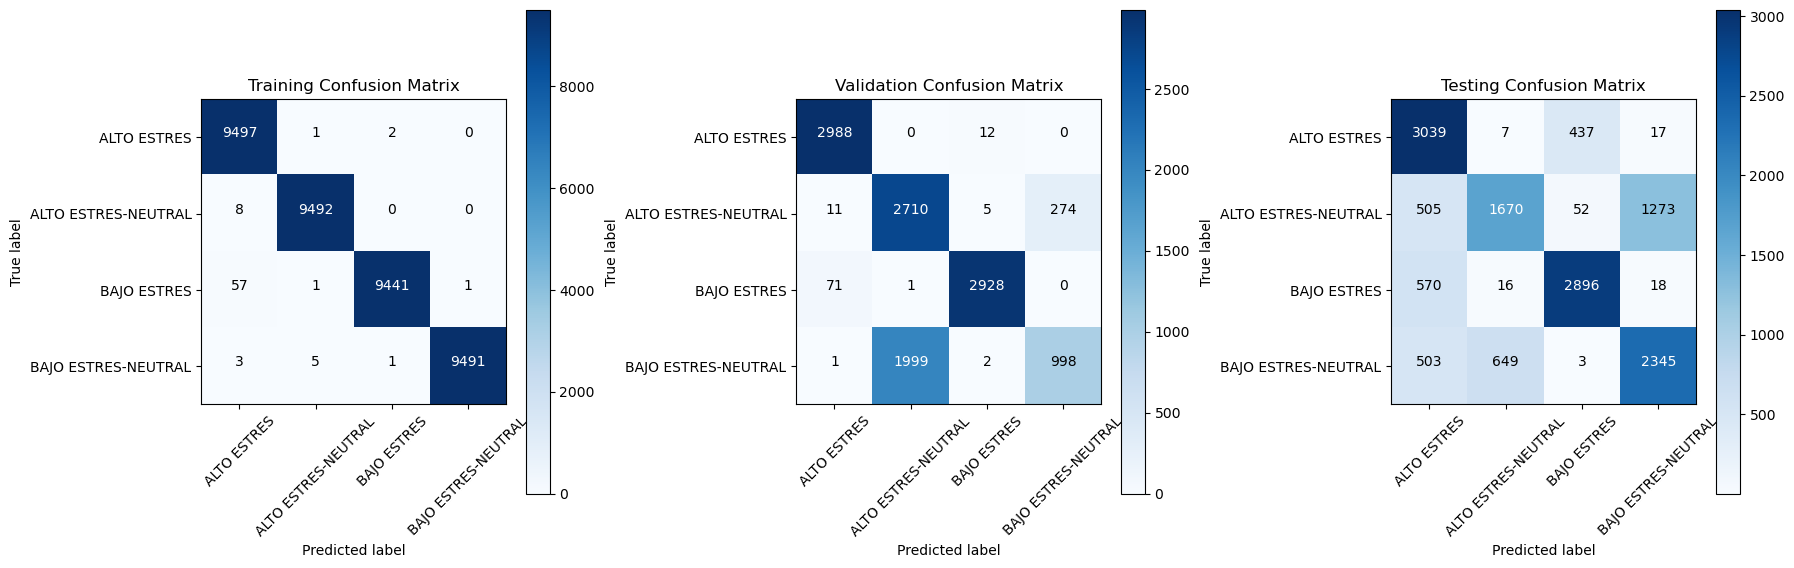

In [15]:
# Asumiendo que tienes 'model' ya entrenado y 'X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test' definidos
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Convertir las predicciones de probabilidades a etiquetas
y_pred_train_labels = np.argmax(y_pred_train, axis=1)
y_pred_val_labels = np.argmax(y_pred_val, axis=1)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

# Etiquetas verdaderas
y_true_train = np.argmax(y_train, axis=1)
y_true_val = np.argmax(y_val, axis=1)
y_true_test = np.argmax(y_test, axis=1)

# Calcular matrices de confusión
cm_train = confusion_matrix(y_true_train, y_pred_train_labels)
cm_val = confusion_matrix(y_true_val, y_pred_val_labels)
cm_test = confusion_matrix(y_true_test, y_pred_test_labels)

# Visualizar orden de las etiquetas
print(label_encoder.classes_)

# Dibujar matrices de confusión
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_confusion_matrix(cm_train, classes=['ALTO ESTRES', 'ALTO ESTRES-NEUTRAL', 'BAJO ESTRES', 'BAJO ESTRES-NEUTRAL'], title='Training Confusion Matrix')

plt.subplot(1, 3, 2)
plot_confusion_matrix(cm_val, classes=['ALTO ESTRES', 'ALTO ESTRES-NEUTRAL', 'BAJO ESTRES', 'BAJO ESTRES-NEUTRAL'], title='Validation Confusion Matrix')

plt.subplot(1, 3, 3)
plot_confusion_matrix(cm_test, classes=['ALTO ESTRES', 'ALTO ESTRES-NEUTRAL', 'BAJO ESTRES', 'BAJO ESTRES-NEUTRAL'], title='Testing Confusion Matrix')
plt.show()

##### Visualizar imágenes de cada etiqueta

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Codificar las etiquetas
label_encoder = LabelEncoder()
etiquetas_encoded = label_encoder.fit_transform(etiquetas)  # Codificar todas las etiquetas
etiquetas_categorical = to_categorical(etiquetas_encoded)  # Convertir a one-hot

# Crear una lista de sujetos únicos
sujetos_unicos = sorted(set(sujetos))
print("Número de sujetos:", len(sujetos_unicos))

# Dividir los sujetos en conjuntos de entrenamiento, validación y prueba
train_suj, test_val_suj = train_test_split(sujetos_unicos, test_size=0.4, random_state=42)
val_suj, test_suj = train_test_split(test_val_suj, test_size=0.5, random_state=42)

# Función para asignar conjunto basado en el sujeto
def asignar_conjunto(sujeto):
    if sujeto in train_suj:
        return 'train'
    elif sujeto in val_suj:
        return 'val'
    else:
        return 'test'


# Asignar cada imagen a un conjunto
conjuntos = np.array([asignar_conjunto(s) for s in sujetos])

# Contar cuántas imágenes hay en cada conjunto
conteo_conjuntos = Counter(conjuntos)
print("Número de imágenes por conjunto:", conteo_conjuntos)

# Separar las imágenes y etiquetas en los conjuntos
X_train = imagenes[conjuntos == 'train']
y_train = etiquetas_categorical[conjuntos == 'train']
X_val = imagenes[conjuntos == 'val']
y_val = etiquetas_categorical[conjuntos == 'val']
X_test = imagenes[conjuntos == 'test']
y_test = etiquetas_categorical[conjuntos == 'test']

# Imprimir las formas de los arrays para verificar
print("Datos de entrenamiento:", X_train.shape, y_train.shape)
print("Datos de validación:", X_val.shape, y_val.shape)
print("Datos de prueba:", X_test.shape, y_test.shape)

# Ver cuales son los sujetos que se encuentran en cada conjunto
print("Sujetos de entrenamiento:", sorted(train_suj))
print("Sujetos de validación:", sorted(val_suj))
print("Sujetos de prueba:", sorted(test_suj))


Número de sujetos: 32
Número de imágenes por conjunto: Counter({'train': 38000, 'test': 14000, 'val': 12000})
Datos de entrenamiento: (38000, 256, 7, 7) (38000, 4)
Datos de validación: (12000, 256, 7, 7) (12000, 4)
Datos de prueba: (14000, 256, 7, 7) (14000, 4)
Sujetos de entrenamiento: ['02', '03', '04', '07', '08', '11', '12', '14', '15', '19', '20', '21', '22', '23', '24', '28', '29', '30', '33']
Sujetos de validación: ['05', '06', '09', '18', '27', '32']
Sujetos de prueba: ['01', '10', '13', '16', '17', '25', '31']


In [ ]:
# Para modelos de clasificación, especialmente en Keras/TensorFlow, las etiquetas deben estar codificadas de manera que cada etiqueta sea un vector binario. Esto se conoce como codificación one-hot
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold

# Configurar validación cruzada con 5 divisiones
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Variables para almacenar los resultados de la validación cruzada
fold_no = 1
acc_per_fold = []
loss_per_fold = []

#### 3.1.2 Modelo LeNet

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Asumiendo que tus datos son características extraídas (256 características por cada una de las 7x7 "imágenes")
def create_model_2():
    model_LeNet = Sequential([
        Flatten(input_shape=(256, 7, 7)), # Aplanamos las características para hacerlas compatibles con capas densas
        Dense(512, activation='relu'), # Aumentamos la dimensión. Ajusta según necesidad.
        Dropout(0.5), # Ayuda a prevenir el sobreajuste
        Dense(120, activation='relu'), # Capa densa con 120 nodos como en LeNet
        Dense(84, activation='relu'), # Capa densa con 84 nodos como en LeNet
        Dense(4, activation='softmax') # Capa de salida para 4 clases
    ])
    return model_LeNet


#### Compilar y entrenar el modelo

In [ ]:
# Antes de entrenar el modelo, debes compilarlo, especificando la función de pérdida y el optimizador que utilizarás.
# Aplicar la codificación one-hot
for train_index, val_index in kf.split(X_train):
    print(f"Fold número {fold_no}")
    # Usar las divisiones correctas para el entrenamiento y la validación
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Comprobar que las formas son correctas
    print(X_train_fold.shape, y_train_fold.shape)
    print(X_val_fold.shape, y_val_fold.shape)

    # Crear el modelo
    model = create_model_2()
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Entrenar el modelo y validar con los datos de validación
    print(f'Training fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold))
    
    # Evaluar el modelo con los datos de test
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    #Incrementar el número de la división
    fold_no += 1

Fold número 1


(30400, 256, 7, 7) (30400, 4)
(7600, 256, 7, 7) (7600, 4)


2024-07-18 02:18:39.264251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 02:18:39.564827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-18 02:18:39.565082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-18 02:18:39.565309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Training fold 1...


2024-07-18 02:18:41.215753: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1525350400 exceeds 10% of free system memory.


Epoch 1/10


2024-07-18 02:18:42.878981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-18 02:18:42.880991: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7eb444cfd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-18 02:18:42.881004: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-18 02:18:42.881008: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-07-18 02:18:42.884431: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-18 02:18:42.976646: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is 

950/950 [==============================] - 5s 3ms/step - loss: 0.1837 - accuracy: 0.9265 - val_loss: 0.0510 - val_accuracy: 0.9842
Epoch 2/10
950/950 [==============================] - 2s 3ms/step - loss: 0.0634 - accuracy: 0.9779 - val_loss: 0.0368 - val_accuracy: 0.9884
Epoch 3/10
950/950 [==============================] - 3s 3ms/step - loss: 0.0490 - accuracy: 0.9829 - val_loss: 0.0274 - val_accuracy: 0.9917
Epoch 4/10
950/950 [==============================] - 3s 3ms/step - loss: 0.0445 - accuracy: 0.9856 - val_loss: 0.0315 - val_accuracy: 0.9896
Epoch 5/10
950/950 [==============================] - 3s 3ms/step - loss: 0.0426 - accuracy: 0.9857 - val_loss: 0.0283 - val_accuracy: 0.9909
Epoch 6/10
950/950 [==============================] - 3s 3ms/step - loss: 0.0324 - accuracy: 0.9892 - val_loss: 0.0381 - val_accuracy: 0.9886
Epoch 7/10
950/950 [==============================] - 3s 3ms/step - loss: 0.0301 - accuracy: 0.9902 - val_loss: 0.0269 - val_accuracy: 0.9926
Epoch 8/10
950/95

2024-07-18 02:19:11.138945: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 702464000 exceeds 10% of free system memory.
2024-07-18 02:19:11.557562: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 702464000 exceeds 10% of free system memory.


Score for fold 1: loss of 2.6089000701904297; accuracy of 70.78571319580078%
Fold número 2
(30400, 256, 7, 7) (30400, 4)
(7600, 256, 7, 7) (7600, 4)
Training fold 2...


2024-07-18 02:19:12.807900: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1525350400 exceeds 10% of free system memory.


Epoch 1/10
950/950 [==============================] - 4s 3ms/step - loss: 0.1955 - accuracy: 0.9201 - val_loss: 0.0463 - val_accuracy: 0.9845
Epoch 2/10
950/950 [==============================] - 3s 3ms/step - loss: 0.0562 - accuracy: 0.9803 - val_loss: 0.0405 - val_accuracy: 0.9880
Epoch 3/10
950/950 [==============================] - 3s 3ms/step - loss: 0.0514 - accuracy: 0.9824 - val_loss: 0.0287 - val_accuracy: 0.9920
Epoch 4/10
950/950 [==============================] - 3s 3ms/step - loss: 0.0425 - accuracy: 0.9863 - val_loss: 0.0399 - val_accuracy: 0.9849
Epoch 5/10
950/950 [==============================] - 3s 3ms/step - loss: 0.0416 - accuracy: 0.9849 - val_loss: 0.0206 - val_accuracy: 0.9937
Epoch 6/10
950/950 [==============================] - 3s 3ms/step - loss: 0.0322 - accuracy: 0.9889 - val_loss: 0.0214 - val_accuracy: 0.9930
Epoch 7/10
950/950 [==============================] - 3s 3ms/step - loss: 0.0314 - accuracy: 0.9890 - val_loss: 0.0187 - val_accuracy: 0.9941
Epoch 

#### Validación del modelo

In [ ]:
# Mostrar los resultados de la validación cruzada
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 2.6089000701904297 - Accuracy: 70.78571319580078%
------------------------------------------------------------------------
> Fold 2 - Loss: 2.517421245574951 - Accuracy: 70.78571319580078%
------------------------------------------------------------------------
> Fold 3 - Loss: 2.9767515659332275 - Accuracy: 71.26428484916687%
------------------------------------------------------------------------
> Fold 4 - Loss: 3.5751631259918213 - Accuracy: 71.29285931587219%
------------------------------------------------------------------------
> Fold 5 - Loss: 2.56207013130188 - Accuracy: 70.21428346633911%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 70.86857080459595 (+- 0.39457142155645575)
> Loss: 2.848061227798462
-------------------------------

##### Calcular la matriz de confusión

438/438 [==============================] - 1s 1ms/step
['ALTO ESTRES' 'ALTO ESTRES-NEUTRAL' 'BAJO ESTRES' 'BAJO ESTRES-NEUTRAL']


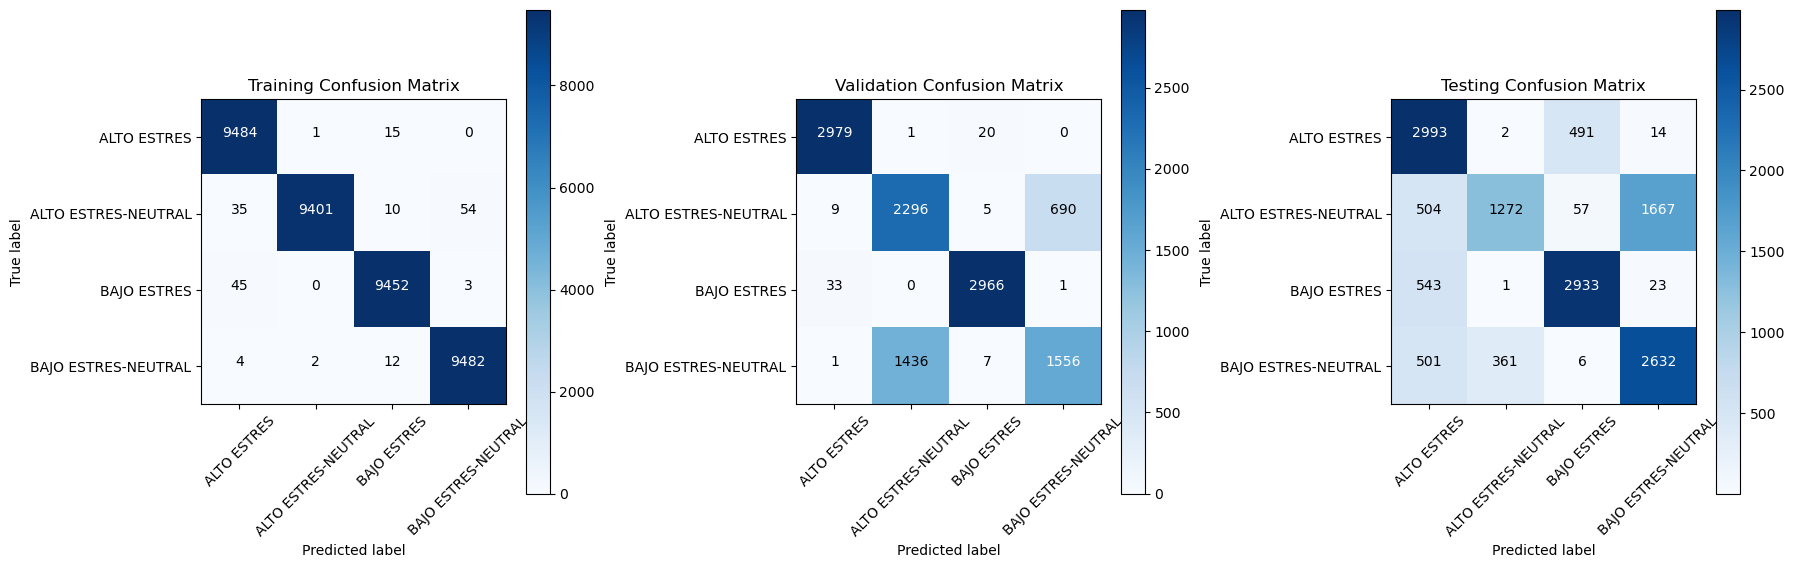

In [ ]:
# Asumiendo que tienes 'model' ya entrenado y 'X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test' definidos
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Convertir las predicciones de probabilidades a etiquetas
y_pred_train_labels = np.argmax(y_pred_train, axis=1)
y_pred_val_labels = np.argmax(y_pred_val, axis=1)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

# Etiquetas verdaderas
y_true_train = np.argmax(y_train, axis=1)
y_true_val = np.argmax(y_val, axis=1)
y_true_test = np.argmax(y_test, axis=1)

# Calcular matrices de confusión
cm_train = confusion_matrix(y_true_train, y_pred_train_labels)
cm_val = confusion_matrix(y_true_val, y_pred_val_labels)
cm_test = confusion_matrix(y_true_test, y_pred_test_labels)

# Visualizar orden de las etiquetas
print(label_encoder.classes_)

# Dibujar matrices de confusión
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_confusion_matrix(cm_train, classes=['ALTO ESTRES', 'ALTO ESTRES-NEUTRAL', 'BAJO ESTRES', 'BAJO ESTRES-NEUTRAL'], title='Training Confusion Matrix')

plt.subplot(1, 3, 2)
plot_confusion_matrix(cm_val, classes=['ALTO ESTRES', 'ALTO ESTRES-NEUTRAL', 'BAJO ESTRES', 'BAJO ESTRES-NEUTRAL'], title='Validation Confusion Matrix')

plt.subplot(1, 3, 3)
plot_confusion_matrix(cm_test, classes=['ALTO ESTRES', 'ALTO ESTRES-NEUTRAL', 'BAJO ESTRES', 'BAJO ESTRES-NEUTRAL'], title='Testing Confusion Matrix')
plt.show()